<a href="https://colab.research.google.com/github/jaydigy/jayg_colab_gate/blob/main/ak_makemore_pt4_by_jayg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

makemore : becoming a backprop ninja

In [6]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline 

In [33]:
!wget "https://raw.githubusercontent.com/jaydigy/jayg_colab_gate/main/names.txt"

--2023-05-24 12:15:41--  https://raw.githubusercontent.com/jaydigy/jayg_colab_gate/main/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.2’

names.txt.2         100%[===================>] 222.80K  --.-KB/s    in 0.01s   

2023-05-24 12:15:41 (22.6 MB/s) - ‘names.txt.2’ saved [228145/228145]



In [34]:
#read all the words
words = open('names.txt', 'r').read().splitlines()
print(words[:8])
print(len(words))
print(max(len(w) for w in words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
32033
15


In [35]:
#build the vocabulary of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [36]:
#build the dataset
block_size = 3 #context length : how many chracters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] #crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])        #80%
Xdev, Ydev = build_dataset(words[n1:n2])    #10%
Xte, Yte = build_dataset(words[n2:])        #10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


ok biolerplate done, now we get to the action :

In [37]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t) :
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

youtube 8:45 below code check

In [38]:
# MLP revisited 
n_embd = 10 #the dimensinaliity of the character embedding vectors
n_hidden = 200 # the number of the neuron in the hidden layer of mlp

g = torch.Generator().manual_seed(214783647) # for reproducibility
C = torch.randn(vocab_size, n_embd,             generator=g)
# layer 1
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g) * (5/3)/((n_embd*block_size)**0.5) # * 0.2 의 토치 kaiser normal 기능구현함
b1 = torch.randn(n_hidden,                      generator=g) * 0.1
# layer 2
W2 = torch.randn((n_hidden, vocab_size),        generator=g) * 0.1
b2 = torch.randn(vocab_size,                    generator=g) * 0.1

#BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1+1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note : I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True  

12297


In [39]:
batch_size = 32
n = batch_size # a shorrter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

In [73]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] #embded the characters into vectors
embcat = emb.view(emb.shape[0], -1) #concatenate the vectors
# linear layer 1
hprebn = embcat @ W1 + b1 #hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff ** 2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note : Bessel's correction )dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer
# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backdrop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
    p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
        norm_logits, logit_maxes, logits, h, hpreact, bnraw,
        bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
        embcat, emb]:
    t.retain_grad()
loss.backward()
loss

tensor(3.3446, grad_fn=<NegBackward0>)

In [16]:
n

32

In [19]:
logprobs[range(n), Yb].shape
#logprobs.shape

torch.Size([32])

In [ ]:
# loss = -(a+b+c) /3 = -a/3 + -b/3 + -c/3
# dloss/da = -1/3

In [22]:
counts.shape, counts_sum_inv.shape

(torch.Size([32, 27]), torch.Size([32, 1]))

In [25]:
# dh = dlogits @ W2.T -> 아래의 텐서 특성을 보고 파악해도 된다. 
# dw2 = h.T @ dlogits -> 아래의 텐서 특성을 보고 파악해도 된다. 
# db2 = dlogits.sum(0)

In [28]:
dlogits.shape, h.shape, W2.shape, b2.shape

(torch.Size([32, 27]),
 torch.Size([32, 200]),
 torch.Size([200, 27]),
 torch.Size([27]))

In [60]:
# exercise 1 : backprop through the whole thing manually,
# backpropagating through exactly all of the variables
# as they are defined in the forward pass above, one by one

# ---------------
# Mein Code GO :)
# ---------------
dlogprobs = torch.zeros_like(logprobs) # loss = -(a+b+c)/3, dloss/da = -1/3
dlogprobs[range(n), Yb] = -1.0/n
dprobs = (1.0/probs) * dlogprobs
dcounts_sum_inv = (dprobs * counts).sum(1, keepdim=True)
dcounts = counts_sum_inv * dprobs
dcounts_sum = dcounts_sum_inv * counts_sum**-2 * -1
dcounts += torch.ones_like(counts) * dcounts_sum
dnorm_logits = counts * dcounts
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1])*dlogit_maxes
dh = dlogits @ W2.T 
dW2 = h.T @ dlogits 
db2 = dlogits.sum(0)
dhpreact = (1.0 - h**2) * dh
dbngain = (bnraw*dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = (-0.5*(bnvar+1e-5)**-1.5) * dbnvar_inv
dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2)*dbnvar
dbndiff += (2*bndiff) * dbndiff2
dhprebn = dbndiff.clone()
dbnmeani = (-torch.ones_like(bndiff) * dbndiff).sum(0)
dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]

cmp('logprobs', dlogprobs, logprobs)
cmp('prob', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('dcounts', dcounts, counts)
cmp('dnorm_logits', dnorm_logits, norm_logits)
cmp('dlogits_max', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('w2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('emb', demb, emb)
cmp('dC', dC, C)


logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
prob            | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
dcounts         | exact: True  | approximate: True  | maxdiff: 0.0
dnorm_logits    | exact: True  | approximate: True  | maxdiff: 0.0
dlogits_max     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
w2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10
bngain          | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09
bnbias          | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09
bnraw   

In [61]:
# Exercise 2 : backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass
# before :
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backdrop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now :
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast-loss).item())



3.344575881958008 diff: 2.384185791015625e-07


In [74]:
# backward pass

dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp('logits', dlogits, logits) # I can only get approximate to be true. max diff is not so big

logits          | exact: False | approximate: True  | maxdiff: 7.683411240577698e-09


In [67]:
F.softmax(logits,1)[0]

tensor([0.0403, 0.0348, 0.0357, 0.0275, 0.0462, 0.0341, 0.0333, 0.0532, 0.0377,
        0.0300, 0.0507, 0.0307, 0.0382, 0.0381, 0.0288, 0.0481, 0.0258, 0.0368,
        0.0385, 0.0322, 0.0400, 0.0462, 0.0440, 0.0292, 0.0299, 0.0352, 0.0346],
       grad_fn=<SelectBackward0>)

In [68]:
dlogits[0]*n

tensor([ 0.0403, -0.9652,  0.0357,  0.0275,  0.0462,  0.0341,  0.0333,  0.0532,
         0.0377,  0.0300,  0.0507,  0.0307,  0.0382,  0.0381,  0.0288,  0.0481,
         0.0258,  0.0368,  0.0385,  0.0322,  0.0400,  0.0462,  0.0440,  0.0292,
         0.0299,  0.0352,  0.0346], grad_fn=<MulBackward0>)

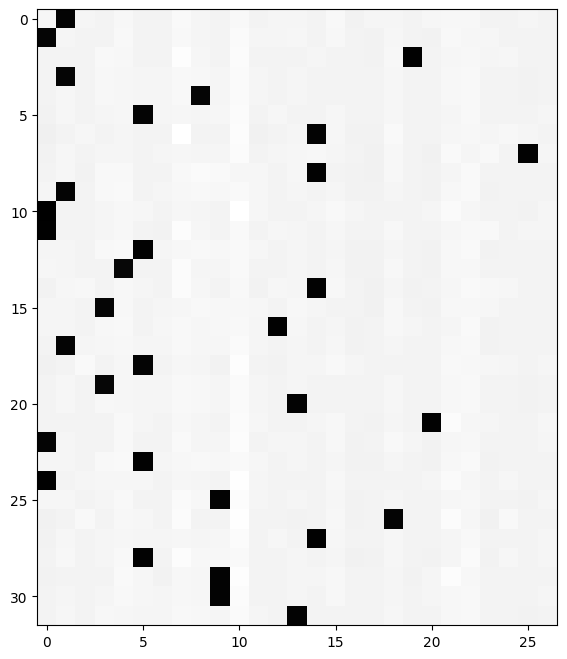

In [69]:
plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach(), cmap='gray')

In [76]:
# Exercise 3 : backprop through batchnorm but all in one go
# to complete this challenge loo at the mathematical expression of the output of batchnorm,
# take the derivatibve w.r.t. its input, simple the expression, and just write it out

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff ** 2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note : Bessel's correction )dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True))
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(0.2534, grad_fn=<MaxBackward1>)


In [78]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbnbias = dhpreact.sum(0, keepdim=True)
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar+1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2)*dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some fo the variables from the forward pass up above)
dhprebn = bngain*bnvar_inv/n * (n * dhpreact - dhpreact.sum(0) - n/(n-1) * bnraw * (dhpreact*bnraw).sum(0))

cmp('hprebn', dhprebn, hprebn) 

hprebn          | exact: False | approximate: True  | maxdiff: 4.0745362639427185e-10


In [85]:
# exercise 4  : putting it all together :
# train the MLP neural net with your own backward pass

# init 
n_embd = 10 #the dimensinaliity of the character embedding vectors
n_hidden = 200 # the number of the neuron in the hidden layer of mlp

g = torch.Generator().manual_seed(214783647) # for reproducibility
C = torch.randn(vocab_size, n_embd,             generator=g)
# layer 1
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g) * (5/3)/((n_embd*block_size)**0.5) # * 0.2 의 토치 kaiser normal 기능구현함
b1 = torch.randn(n_hidden,                      generator=g) * 0.1
# layer 2
W2 = torch.randn((n_hidden, vocab_size),        generator=g) * 0.1
b2 = torch.randn(vocab_size,                    generator=g) * 0.1

#BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1+1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True  

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad() :

    # kick off optimization
    for i in range(max_steps):

        #minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

        #forward pass    
        emb = C[Xb] #embded the characters into vectors
        embcat = emb.view(emb.shape[0], -1) #concatenate the vectors
        # linear layer 
        hprebn = embcat @ W1 + b1 #hidden layer pre-activation
        # BatchNorm layer
        bnmean = hprebn.mean(0, keepdim=True)
        # bndiff = hprebn - bnmeani
        # bndiff2 = bndiff ** 2
        bnvar = hprebn.var(0, keepdim=True, unbiased=True) # note : Bessel's correction )dividing by n-1, not n)
        bnvar_inv = (bnvar + 1e-5)**-0.5
        bnraw = (hprebn-bnmean) * bnvar_inv
        hpreact = bngain * bnraw + bnbias
        # Non-linearity
        h = torch.tanh(hpreact) # hidden layer
        # Linear layer 2
        logits = h @ W2 + b2 # output layer
        loss = F.cross_entropy(logits, Yb) #loss function

        # PyTorch backward pass
        for p in parameters:
            p.grad = None
        #loss.backward()

        # manual backprop!
        dlogits = F.softmax(logits, 1)
        dlogits[range(n), Yb] -= 1
        dlogits /= n
        # 2nd layer backprop
        dh = dlogits @ W2.T 
        dW2 = h.T @ dlogits 
        db2 = dlogits.sum(0)
        # tanh
        dhpreact = (1.0 - h**2) * dh
        # bathnorm backprop
        dbngain = (bnraw*dhpreact).sum(0, keepdim=True)
        dbnbias = dhpreact.sum(0, keepdim=True)
        dhprebn = bngain*bnvar_inv/n * (n * dhpreact - dhpreact.sum(0) - n/(n-1) * bnraw * (dhpreact*bnraw).sum(0))
        # 1st layer
        dembcat = dhprebn @ W1.T
        dW1 = embcat.T @ dhprebn
        db1 = dhprebn.sum(0)
        # embedding
        demb = dembcat.view(emb.shape)
        dC = torch.zeros_like(C)
        for k in range(Xb.shape[0]):
            for j in range(Xb.shape[1]):
                ix = Xb[k,j]
                dC[ix] += demb[k,j]
        grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
        #--------------------

        # update
        lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
        for p, grad in zip(parameters, grads):
            #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
            p.data += -lr * grad # new way of swole doge TODO: enable

        # track stats
        if i % 10000 == 0: # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())

    #   if i >= 100: # TODO: delete early breaking when you're ready to train the full net
    #     break


12297
      0/ 200000: 3.5949
  10000/ 200000: 2.2800
  20000/ 200000: 2.1599
  30000/ 200000: 1.9092
  40000/ 200000: 2.0792
  50000/ 200000: 2.2160
  60000/ 200000: 2.3040
  70000/ 200000: 1.9227
  80000/ 200000: 2.1023
  90000/ 200000: 1.7679
 100000/ 200000: 1.8332
 110000/ 200000: 2.2940
 120000/ 200000: 2.4554
 130000/ 200000: 2.0557
 140000/ 200000: 2.4813
 150000/ 200000: 2.2429
 160000/ 200000: 1.6935
 170000/ 200000: 2.0374
 180000/ 200000: 1.7214
 190000/ 200000: 1.9209


In [ ]:
# useful for checking your gradients
# for p,g in zip(parameters, grads):
#   cmp(str(tuple(p.shape)), g, p)

In [86]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [87]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.070340633392334
val 2.112194061279297


In [88]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # ------------
      # forward pass:
      # Embedding
      emb = C[torch.tensor([context])] # (1,block_size,d)      
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # ------------
      # Sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

montaimyah.
see.
madhayla.
reimani.
jarlee.
adelynnelin.
shy.
jenne.
elies.
anar.
katzion.
kalin.
shabergiaghanst.
jair.
jennex.
terian.
brence.
ryyah.
faeha.
kayshayan.
